# Tanmay Garg
## CS20BTECH11063
## Deep Learning Assignment 5

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
import torch.functional as F
import torch.nn as nn
from sklearn.utils import shuffle
import PIL
from PIL import Image
# import cv2
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from tqdm import tqdm

np.random.seed(0)
torch.cuda.is_available()

/home/cs20btech11063/anaconda3/envs/gpu_env2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

## MNIST Dataset

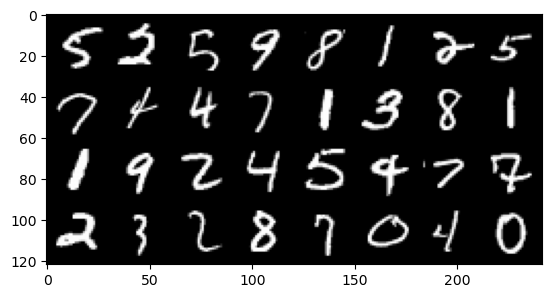

    5     2     5     9     8     1     2     5     7     4     4     7     1     3     8     1     1     9     2     4     5     4     7     7     2     3     2     8     7     0     4     0


In [2]:
# MNIST Dataset Loader

def get_mnist_data(batch_size=32, shuffle=True):
    transform = transforms.Compose([
                                    transforms.ToTensor(), 
                                    # transforms.Normalize((0.1307,), (0.3081,))
                                ])
    
    train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
    
    return train_dataset, test_dataset, train_dataloader, test_dataloader

# Data Loader
train_ds, test_ds, train_dl, test_dl = get_mnist_data(batch_size=32, shuffle=True)

# Visualize the data
def show_image(img):
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()
    plt.close()

# Get some random training images
dataiter = iter(train_dl)
images, labels = dataiter.next()

# Show images
show_image(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % labels[j].item() for j in range(32)))

def denormalize(img):
    transform = transforms.Compose([
                                    transforms.Normalize((-0.1307/0.3081,), (1/0.3081,))
                                ])
    return transform(img)

## Autoencoder

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self, hidden_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(True),
            nn.Linear(128, hidden_dim),
            nn.ReLU(True)
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 784),
            nn.Sigmoid()
            )     

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    # def train_model(self, train_loader, test_loader, optimizer, criterion, device, epochs=10, lr=0.001):
    #     self.to(device)
    #     train_loss = []
    #     test_loss = []
    #     for epoch in range(epochs):
    #         train_loss.append(self.train_epoch(train_loader, optimizer, criterion, device))
    #         test_loss.append(self.test_model(test_loader, criterion, device))
    #         print('Epoch: {}/{}\t Train Loss: {:.6f}\t Test Loss: {:.6f}'.format(epoch+1, epochs, train_loss[-1], test_loss[-1]))
        
    #     return train_loss, test_loss
    
    # def train_epoch(self, train_loader, optimizer, criterion, device):
    #     train_loss = 0.0
    #     self.train()
    #     for batch_idx, data in enumerate(train_loader):
    #         inputs, labels = data
            
    #         inputs = inputs.to(device)
    #         inputs = inputs.view(inputs.size(0), -1)
            
    #         optimizer.zero_grad()
    #         outputs = self(inputs)
    #         loss = criterion(outputs, inputs)
    #         loss.backward()
    #         optimizer.step()
            
    #         train_loss += loss.item()
            
    #     train_loss = train_loss / len(train_loader)
        
    #     return train_loss
    
    # def test_model(self, test_loader, criterion, device):
    #     test_loss = 0.0
    #     self.eval()
    #     for batch_idx, data in enumerate(test_loader):
    #         inputs, labels = data
            
    #         inputs = inputs.to(device)
    #         inputs = inputs.view(inputs.size(0), -1)
            
    #         outputs = self(inputs)
    #         loss = criterion(outputs, inputs)
            
    #         test_loss += loss.item()
            
    #     test_loss = test_loss / len(test_loader)
        
    #     return test_loss
    
    def train_model(self, train_loader, test_loader, optimizer, criterion, device, epochs=10, lr=0.001):
        self.to(device)
        train_loss = []
        test_loss = []
        for epoch in range(epochs):
            train_loss.append(self.train_epoch(train_loader, optimizer, criterion, device))
            test_loss.append(self.test_model(test_loader, criterion, device))
            print(f'Epoch: {epoch+1}/{epochs}\t Train Loss: {train_loss[-1]:.6f}\t Test Loss: {test_loss[-1]:.6f}')
        
        return train_loss, test_loss

    def train_epoch(self, train_loader, optimizer, criterion, device):
        train_loss = 0.0
        self.train()
        for batch_idx, data in enumerate(tqdm(train_loader, desc="Training", leave=False)):
            inputs, labels = data
            
            inputs = inputs.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            
            optimizer.zero_grad()
            outputs = self(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss = train_loss / len(train_loader)
        
        return train_loss

    def test_model(self, test_loader, criterion, device):
        test_loss = 0.0
        self.eval()
        for batch_idx, data in enumerate(tqdm(test_loader, desc="Testing", leave=False)):
            inputs, labels = data
            
            inputs = inputs.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            
            outputs = self(inputs)
            loss = criterion(outputs, inputs)
            
            test_loss += loss.item()
        
        test_loss = test_loss / len(test_loader)
        
        return test_loss

def display_reconstructions(model, test_loader, device):
    model.eval()
    dataiter = iter(test_loader)
    # dataiter.next()
    images, labels = dataiter.next()
    images = images.to(device)
    input_img = images
    images = images.view(images.size(0), -1)
    outputs = model(images)
    outputs = outputs.view(outputs.size(0), 1, 28, 28)
    outputs = outputs.cpu()
    # print(outputs.shape)
    # print(input_img.shape)
    print("Reconstructed Images:")
    show_image(torchvision.utils.make_grid(outputs.detach().cpu()))
    print("Original Images:")
    show_image(torchvision.utils.make_grid(input_img.detach().cpu()))
    return

def latent_space_gen(model, input_img1, input_img2, device, num_samples=10):
    model.eval()
    input_img1 = input_img1.to(device)
    input_img2 = input_img2.to(device)
    input_img1 = input_img1.view(input_img1.size(0), -1)
    input_img2 = input_img2.view(input_img2.size(0), -1)
    output_img1 = model.encoder(input_img1)
    output_img2 = model.encoder(input_img2)
    
    sampled_imgs = []
    for alpha in np.linspace(0, 1, num_samples):
        sampled_img = output_img1 + alpha * (output_img2 - output_img1)
        sampled_img = model.decoder(sampled_img)
        sampled_img = sampled_img.view(sampled_img.size(0), 1, 28, 28)
        sampled_imgs.append(sampled_img)
    
    sampled_imgs = torch.cat(sampled_imgs, dim=0)
    sampled_imgs = sampled_imgs.cpu()
    # show_image(torchvision.utils.make_grid(sampled_imgs.detach()))
    return sampled_imgs


==========Training AutoEncoder with hidden dimension = 32==========


Epoch: 1/10	 Train Loss: 0.029938	 Test Loss: 0.016673


Epoch: 2/10	 Train Loss: 0.014394	 Test Loss: 0.012221


Epoch: 3/10	 Train Loss: 0.011540	 Test Loss: 0.010527


Epoch: 4/10	 Train Loss: 0.010361	 Test Loss: 0.009609


Epoch: 5/10	 Train Loss: 0.009661	 Test Loss: 0.009109


Epoch: 6/10	 Train Loss: 0.009193	 Test Loss: 0.008741


Epoch: 7/10	 Train Loss: 0.008835	 Test Loss: 0.008394


Epoch: 8/10	 Train Loss: 0.008570	 Test Loss: 0.008243


Epoch: 9/10	 Train Loss: 0.008351	 Test Loss: 0.008099


Epoch: 10/10	 Train Loss: 0.008164	 Test Loss: 0.007912
==========Reconstruction of the images from the test set==========
Reconstructed Images:


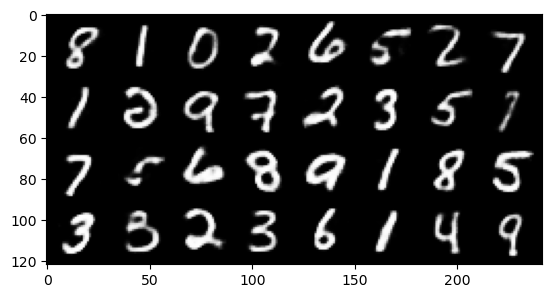

Original Images:


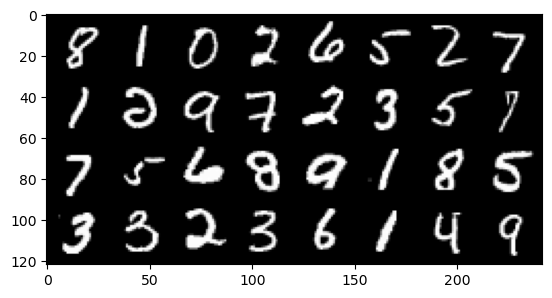

==========Reconstruction of the images from the train set==========
Reconstructed Images:


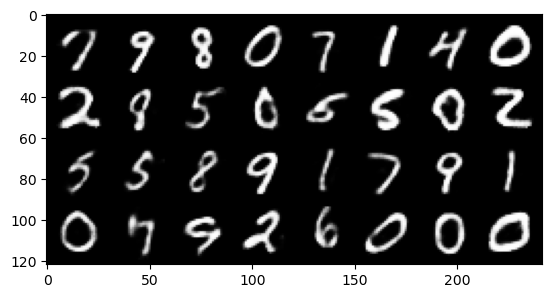

Original Images:


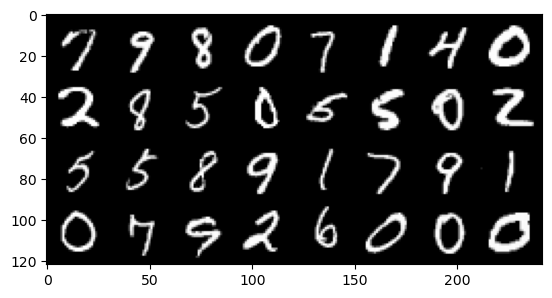

==========Reconstruction of the images from the latent space==========


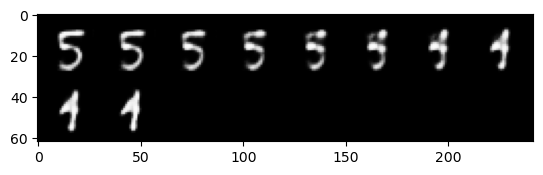

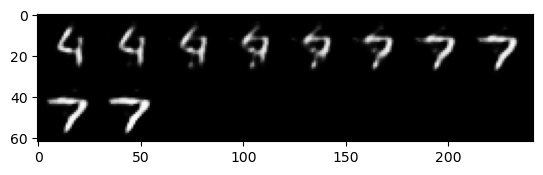

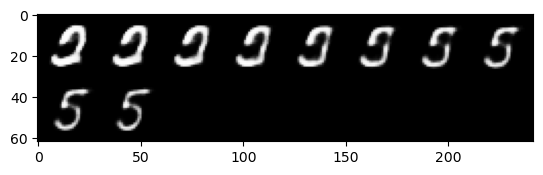

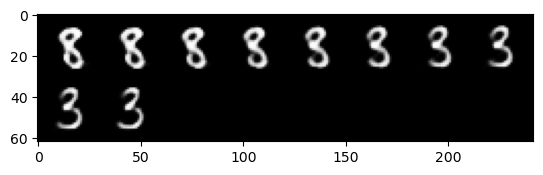

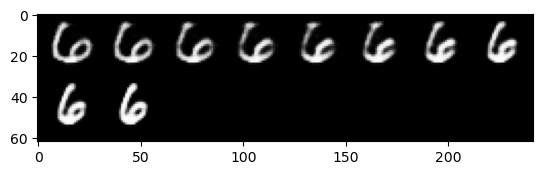

In [4]:
AutoEn_32  = AutoEncoder(hidden_dim=32)
optimizer = optim.Adam(AutoEn_32.parameters(), lr=0.001)
criterion = nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("==========Training AutoEncoder with hidden dimension = 32==========")
train_loss, test_loss = AutoEn_32.train_model(train_dl, test_dl, optimizer, criterion, device, epochs=10, lr=0.001)

print("==========Reconstruction of the images from the test set==========")
display_reconstructions(AutoEn_32, test_dl, device)

print("==========Reconstruction of the images from the train set==========")
display_reconstructions(AutoEn_32, train_dl, device)

# Taking random images and reconstructing images from a random point which is in between the two samples in the latent space
print("==========Reconstruction of the images from the latent space==========")
num_pairs = 5
for i in range(num_pairs):
    dataiter = iter(test_dl)
    images, labels = dataiter.next()
    sampled_imgs = latent_space_gen(AutoEn_32, images[0], images[1], device)
    show_image(torchvision.utils.make_grid(sampled_imgs.detach()))

    

==========Training AutoEncoder with hidden dimension = 64==========


Epoch: 1/10	 Train Loss: 0.029703	 Test Loss: 0.015310


Epoch: 2/10	 Train Loss: 0.013053	 Test Loss: 0.010737


Epoch: 3/10	 Train Loss: 0.010091	 Test Loss: 0.009024


Epoch: 4/10	 Train Loss: 0.008450	 Test Loss: 0.007839


Epoch: 5/10	 Train Loss: 0.007464	 Test Loss: 0.006883


Epoch: 6/10	 Train Loss: 0.006867	 Test Loss: 0.006449


Epoch: 7/10	 Train Loss: 0.006423	 Test Loss: 0.006092


Epoch: 8/10	 Train Loss: 0.006074	 Test Loss: 0.005853


Epoch: 9/10	 Train Loss: 0.005832	 Test Loss: 0.005678


Epoch: 10/10	 Train Loss: 0.005624	 Test Loss: 0.005434
==========Reconstruction of the images from the test set==========
Reconstructed Images:


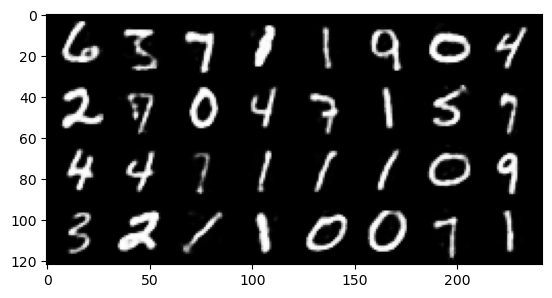

Original Images:


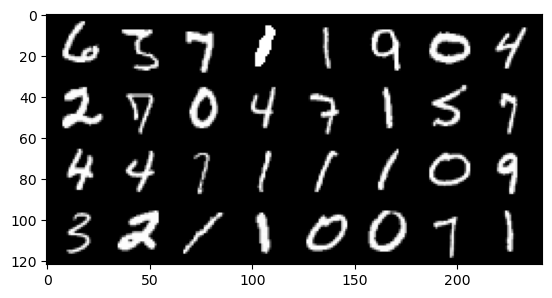

==========Reconstruction of the images from the train set==========
Reconstructed Images:


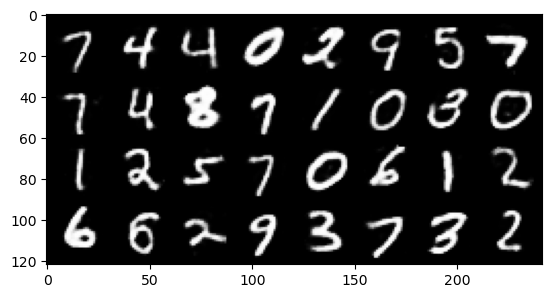

Original Images:


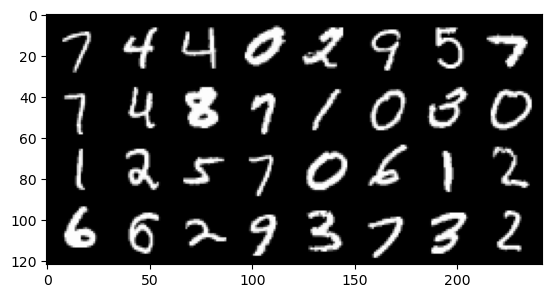

==========Reconstruction of the images from the latent space==========


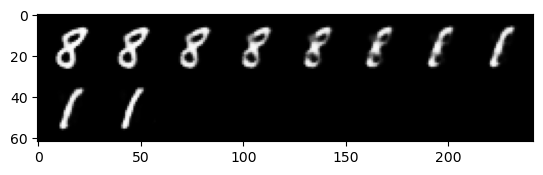

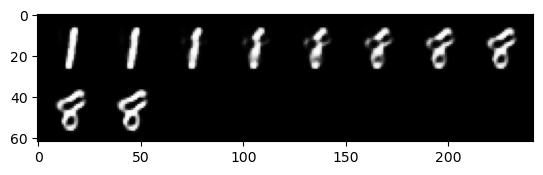

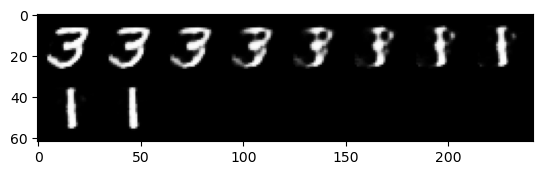

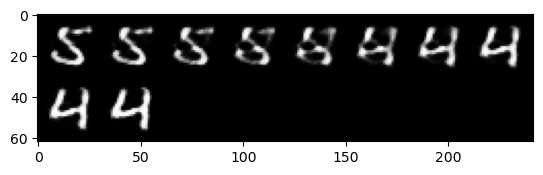

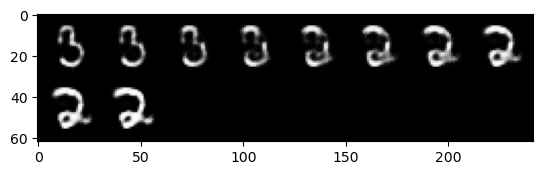

In [5]:
AutoEn_64  = AutoEncoder(hidden_dim=64)
optimizer = optim.Adam(AutoEn_64.parameters(), lr=0.001)
criterion = nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("==========Training AutoEncoder with hidden dimension = 64==========")
train_loss, test_loss = AutoEn_64.train_model(train_dl, test_dl, optimizer, criterion, device, epochs=10, lr=0.001)

print("==========Reconstruction of the images from the test set==========")
display_reconstructions(AutoEn_64, test_dl, device)

print("==========Reconstruction of the images from the train set==========")
display_reconstructions(AutoEn_64, train_dl, device)

# Taking random images and reconstructing images from a random point which is in between the two samples in the latent space
print("==========Reconstruction of the images from the latent space==========")
num_pairs = 5
for i in range(num_pairs):
    dataiter = iter(test_dl)
    images, labels = dataiter.next()
    sampled_imgs = latent_space_gen(AutoEn_64, images[0], images[1], device)
    show_image(torchvision.utils.make_grid(sampled_imgs.detach()))

    
# AutoEn_64  = AutoEncoder(hidden_dim=64)
# optimizer = optim.Adam(AutoEn_64.parameters(), lr=0.001)
# criterion = nn.MSELoss()
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# train_loss, test_loss = AutoEn_64.train_AutoEn_64(train_dl, test_dl, optimizer, criterion, device, epochs=10, lr=0.001)

# display_reconstructions(AutoEn_64, test_dl, device)
# display_reconstructions(AutoEn_64, train_dl, device)

# num_pairs = 5
# for i in range(num_pairs):
#     dataiter = iter(test_dl)
#     images, labels = dataiter.next()
#     sampled_imgs = latent_space_gen(AutoEn_64, images[0], images[1], device)
#     show_image(torchvision.utils.make_grid(sampled_imgs.detach()))

==========Training AutoEncoder with hidden dimension = 32 with weight decay==========


Epoch: 1/10	 Train Loss: 0.039667	 Test Loss: 0.028568


Epoch: 2/10	 Train Loss: 0.027761	 Test Loss: 0.026299


Epoch: 3/10	 Train Loss: 0.026730	 Test Loss: 0.025943


Epoch: 4/10	 Train Loss: 0.026315	 Test Loss: 0.025637


Epoch: 5/10	 Train Loss: 0.026094	 Test Loss: 0.025416


Epoch: 6/10	 Train Loss: 0.025913	 Test Loss: 0.025571


Epoch: 7/10	 Train Loss: 0.025814	 Test Loss: 0.025207


Epoch: 8/10	 Train Loss: 0.025639	 Test Loss: 0.024818


Epoch: 9/10	 Train Loss: 0.025078	 Test Loss: 0.024442


Epoch: 10/10	 Train Loss: 0.024908	 Test Loss: 0.024395
==========Reconstruction of the images from the test set==========
Reconstructed Images:


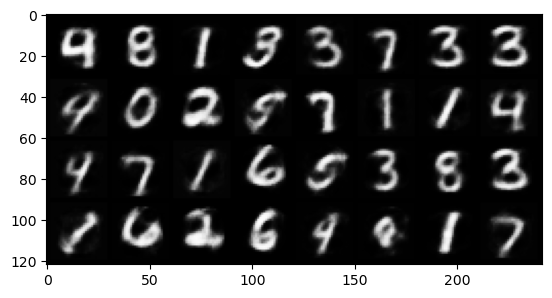

Original Images:


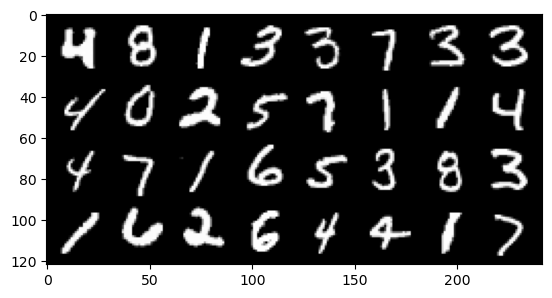

==========Reconstruction of the images from the train set==========
Reconstructed Images:


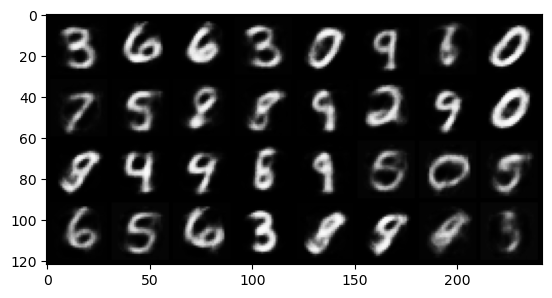

Original Images:


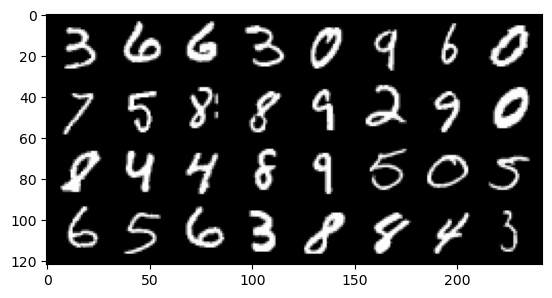

==========Reconstruction of the images from the latent space==========


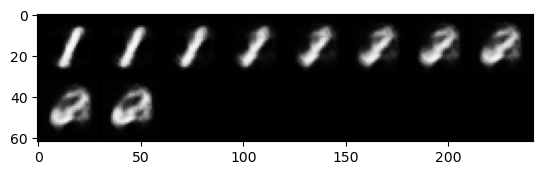

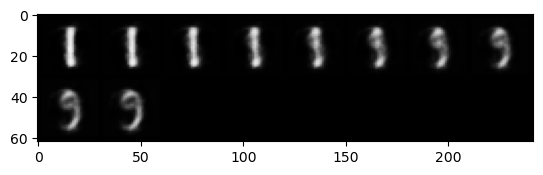

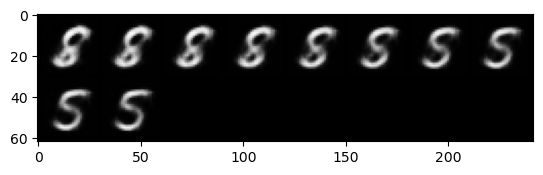

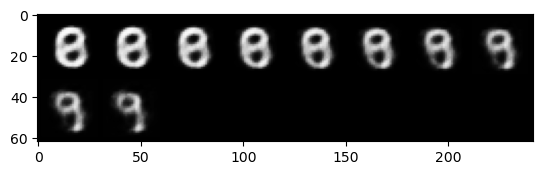

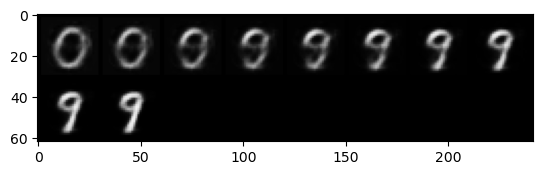

In [6]:
AutoEn_32_reg  = AutoEncoder(hidden_dim=32)
optimizer = optim.Adam(AutoEn_32_reg.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("==========Training AutoEncoder with hidden dimension = 32 with weight decay==========")
train_loss, test_loss = AutoEn_32_reg.train_model(train_dl, test_dl, optimizer, criterion, device, epochs=10, lr=0.001)

print("==========Reconstruction of the images from the test set==========")
display_reconstructions(AutoEn_32_reg, test_dl, device)

print("==========Reconstruction of the images from the train set==========")
display_reconstructions(AutoEn_32_reg, train_dl, device)

# Taking random images and reconstructing images from a random point which is in between the two samples in the latent space
print("==========Reconstruction of the images from the latent space==========")
num_pairs = 5
for i in range(num_pairs):
    dataiter = iter(test_dl)
    images, labels = dataiter.next()
    sampled_imgs = latent_space_gen(AutoEn_32_reg, images[0], images[1], device)
    show_image(torchvision.utils.make_grid(sampled_imgs.detach()))

    

## Variational Autoencoder

In [7]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, hidden_dim):
        super(VariationalAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True)
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 784),
            nn.Sigmoid()    
            )
        
        self.fc_mu = nn.Linear(128, hidden_dim)
        # variance in log form
        self.fc_var = nn.Linear(128, hidden_dim)
        
    def sampling_method(self, mu, var):
        std = torch.exp(0.5 * var)
        return mu + torch.randn(std.size(), device=std.device) * std
    
    def forward(self, x):
        x = self.encoder(x)
        
        mu = self.fc_mu(x)
        var = self.fc_var(x)
        
        z = self.sampling_method(mu, var)
        
        x = self.decoder(z)
        
        return x, mu, var
    
    # def train_model(self, train_loader, test_loader, optimizer, criterion, device, epochs=10, lr=0.001):
    #     self.to(device)
    #     train_loss = []
    #     test_loss = []
    #     for epoch in range(epochs):
    #         train_loss.append(self.train_epoch(train_loader, optimizer, criterion, device))
    #         test_loss.append(self.test_model(test_loader, criterion, device))
    #         print('Epoch: {}/{}\t Train Loss: {:.6f}\t Test Loss: {:.6f}'.format(epoch+1, epochs, train_loss[-1], test_loss[-1]))
        
    #     return train_loss, test_loss
    
    # # def train_epoch(self, train_loader, optimizer, criterion, device):
    # #     train_loss = 0.0
    # #     self.train()
    # #     for batch_idx, data in enumerate(train_loader):
    # #         inputs, labels = data
            
    # #         inputs = inputs.to(device)
    # #         inputs = inputs.view(inputs.size(0), -1)
            
    # #         optimizer.zero_grad()
    # #         outputs, mu, var = self(inputs)
    # #         loss = criterion(outputs, inputs, mu, var)
    # #         loss.backward()
    # #         optimizer.step()
            
    # #         train_loss += loss.item()
            
    # #     train_loss = train_loss / len(train_loader)
        
    # #     return train_loss
    
    # def train_epoch(self, train_loader, optimizer, criterion, device):
    #     train_loss = 0.0
    #     self.train()
    #     for batch_idx, data in tqdm(enumerate(train_loader), total=len(train_loader)):
    #         inputs, labels = data
            
    #         inputs = inputs.to(device)
    #         inputs = inputs.view(inputs.size(0), -1)
            
    #         optimizer.zero_grad()
    #         outputs, mu, var = self(inputs)
    #         loss = criterion(outputs, inputs, mu, var)
    #         loss.backward()
    #         optimizer.step()
            
    #         train_loss += loss.item()
            
    #     train_loss = train_loss / len(train_loader)
        
    #     return train_loss

    # def test_model(self, test_loader, criterion, device):
    #     test_loss = 0.0
    #     self.eval()
    #     for batch_idx, data in enumerate(test_loader):
    #         inputs, labels = data
            
    #         inputs = inputs.to(device)
    #         inputs = inputs.view(inputs.size(0), -1)
            
    #         outputs, mu, var = self(inputs)
    #         loss = criterion(outputs, inputs, mu, var)
            
    #         test_loss += loss.item()
            
    #     test_loss = test_loss / len(test_loader)
        
    #     return test_loss
    
    def train_model(self, train_loader, test_loader, optimizer, criterion, device, epochs=10, lr=0.001):
        self.to(device)
        train_loss = []
        test_loss = []
        for epoch in range(epochs):
            train_loss.append(self.train_epoch(train_loader, optimizer, criterion, device))
            test_loss.append(self.test_model(test_loader, criterion, device))
            print(f'Epoch: {epoch+1}/{epochs}\t Train Loss: {train_loss[-1]:.6f}\t Test Loss: {test_loss[-1]:.6f}')
        
        return train_loss, test_loss

    def train_epoch(self, train_loader, optimizer, criterion, device):
        train_loss = 0.0
        self.train()
        for batch_idx, data in enumerate(tqdm(train_loader, desc="Training", leave=False)):
            inputs, labels = data
            
            inputs = inputs.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            
            optimizer.zero_grad()
            outputs, mu, var = self(inputs)
            loss = criterion(outputs, inputs, mu, var)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss = train_loss / len(train_loader)
        
        return train_loss

    def test_model(self, test_loader, criterion, device):
        test_loss = 0.0
        self.eval()
        for batch_idx, data in enumerate(tqdm(test_loader, desc="Testing", leave=False)):
            inputs, labels = data
            
            inputs = inputs.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            
            outputs, mu, var = self(inputs)
            loss = criterion(outputs, inputs, mu, var)
            
            test_loss += loss.item()
        
        test_loss = test_loss / len(test_loader)
        
        return test_loss

def vae_loss(recontruction, x, mu, var):
    reconstruc_loss_class = nn.MSELoss(reduction='sum')
    reconstruc_loss = reconstruc_loss_class(recontruction, x)
    kl_div_loss = -0.5 * torch.sum(1 + var - mu.square() - var.exp(), dim=1)
    kl_div_loss = torch.mean(kl_div_loss)
    
    total_loss = reconstruc_loss + kl_div_loss
    return total_loss


def display_reconstructions(model, test_loader, device):
    model.eval()
    dataiter = iter(test_loader)
    # dataiter.next()
    images, labels = dataiter.next()
    images = images.to(device)
    input_img = images
    images = images.view(images.size(0), -1)
    outputs, mu, var = model(images)
    outputs = outputs.view(outputs.size(0), 1, 28, 28)
    outputs = outputs.cpu()
    # print(outputs.shape)
    # print(input_img.shape)
    show_image(torchvision.utils.make_grid(outputs.detach()))
    show_image(torchvision.utils.make_grid(input_img.detach().cpu()))
     
        

Epoch: 1/20	 Train Loss: 848.577979	 Test Loss: 498.819050


Epoch: 2/20	 Train Loss: 440.467087	 Test Loss: 393.722781


Epoch: 3/20	 Train Loss: 373.242267	 Test Loss: 356.556152


Epoch: 4/20	 Train Loss: 344.141882	 Test Loss: 331.766325


Epoch: 5/20	 Train Loss: 326.918333	 Test Loss: 315.904954


Epoch: 6/20	 Train Loss: 316.088589	 Test Loss: 312.023972


Epoch: 7/20	 Train Loss: 307.031207	 Test Loss: 301.613918


Epoch: 8/20	 Train Loss: 300.121064	 Test Loss: 299.790589


Epoch: 9/20	 Train Loss: 294.640983	 Test Loss: 295.574835


Epoch: 10/20	 Train Loss: 290.065667	 Test Loss: 289.971080


Epoch: 11/20	 Train Loss: 286.215144	 Test Loss: 287.920277


Epoch: 12/20	 Train Loss: 282.401212	 Test Loss: 287.733731


Epoch: 13/20	 Train Loss: 279.739796	 Test Loss: 287.647476


Epoch: 14/20	 Train Loss: 276.802224	 Test Loss: 282.846660


Epoch: 15/20	 Train Loss: 274.498696	 Test Loss: 279.581132


Epoch: 16/20	 Train Loss: 272.413065	 Test Loss: 279.838827


Epoch: 17/20	 Train Loss: 270.574744	 Test Loss: 276.716512


Epoch: 18/20	 Train Loss: 268.620059	 Test Loss: 276.018587


Epoch: 19/20	 Train Loss: 266.867643	 Test Loss: 271.589847


Epoch: 20/20	 Train Loss: 265.209357	 Test Loss: 275.081983
==========Reconstruction of images from test set==========


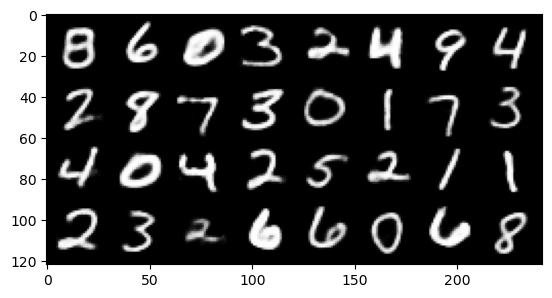

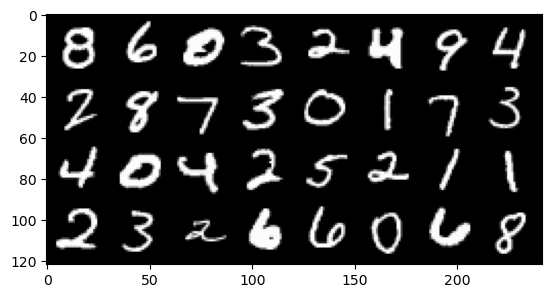

In [8]:
vae_model = VariationalAutoEncoder(hidden_dim=16)
optimizer = optim.Adam(vae_model.parameters(), lr=0.001)
criterion = vae_loss
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loss, test_loss = vae_model.train_model(train_dl, test_dl, optimizer, criterion, device, epochs=20, lr=0.001)

print("==========Reconstruction of images from test set==========")
display_reconstructions(vae_model, test_dl, device)

==========Randomly generated images==========


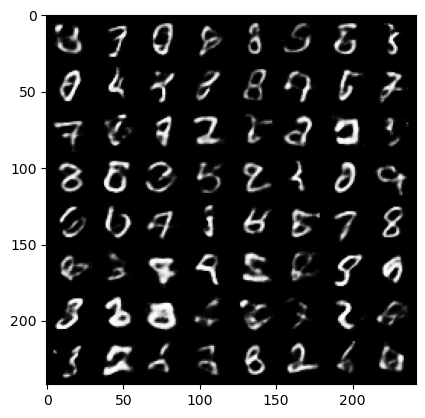

In [9]:
# randomly generate a sample from the latent space
def generate_sample(model, device):
    model.eval()
    z = torch.randn(1, 16).to(device)
    output = model.decoder(z)
    output = output.view(output.size(0), 1, 28, 28)
    output = output.cpu()
    # show_image(torchvision.utils.make_grid(output.detach()))
    return output.detach()

print("==========Randomly generated images==========")

gen_img_list = []
for i in range(64):
    gen_img_list.append(generate_sample(vae_model, device).squeeze(0))

show_image(torchvision.utils.make_grid(gen_img_list))

## Self Attention

In [10]:
# Loading CIFAR10 dataset

def load_cifar10(batch_size=32):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return trainloader, testloader, trainset, testset

train_dl, test_dl, train_set, test_set = load_cifar10(batch_size=32)


Files already downloaded and verified
Files already downloaded and verified


In [11]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.chanel_in = in_dim
        self.f = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.g = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.h = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.softmax  = nn.Softmax(dim=-1)
        self.gamma = nn.Parameter(torch.zeros(1))
        
    def forward(self, x):
        N, C, W, H = x.size()
        f_x = self.f(x).view(N, -1, W*H).permute(0, 2, 1)
        g_x = self.g(x).view(N, -1, W*H)
        h_x = self.h(x).view(N, -1, W*H)
        
        attention_map = torch.bmm(f_x, g_x)
        attention_map = self.softmax(attention_map)
        
        output = torch.bmm(h_x, attention_map.permute(0, 2, 1))
        
        output = output.view(N, C, W, H)
        output = self.gamma * output + x
        return output
    
class SelfAttentionCNN(nn.Module):
    # def __init__(self, in_dim=128):
    #     super(SelfAttentionCNN, self).__init__()
        
    #     self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
    #     self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    #     self.conv3 = nn.Conv2d(in_channels=64, out_channels=in_dim, kernel_size=3, stride=1, padding=1)
    #     self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
    #     self.fc1 = nn.Linear(in_dim*4*4, 512)
    #     self.fc2 = nn.Linear(512, 10)
    #     self.attention_layer = SelfAttention(in_dim=in_dim)
    
    # def forward(self, x):
    #     # print(x.shape)
    #     x = torch.nn.functional.relu(self.conv1(x))
    #     # print(x.shape)
    #     x = self.max_pool(x)
    #     # print(x.shape)
    #     x = torch.nn.functional.relu(self.conv2(x))
    #     # print(x.shape)
    #     x = self.max_pool(x)
    #     # print(x.shape)
    #     x = torch.nn.functional.relu(self.conv3(x))
    #     # print(x.shape)
    #     x = self.attention_layer(x)
    #     # print(x.shape)
    #     x = self.max_pool(x)
    #     x = x.view(-1, 128*4*4)
    #     x = torch.nn.functional.relu(self.fc1(x))
    #     x = self.fc2(x)
    #     return x
    
    # def __init__(self, in_dim=128):
    #     super(SelfAttentionCNN, self).__init__()

    #     self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
    #     self.bn1 = nn.BatchNorm2d(32)
    #     self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    #     self.bn2 = nn.BatchNorm2d(64)
    #     self.conv3 = nn.Conv2d(in_channels=64, out_channels=in_dim, kernel_size=3, stride=1, padding=1)
    #     self.bn3 = nn.BatchNorm2d(in_dim)
    #     self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
    #     self.fc1 = nn.Linear(in_dim * 4 * 4, 512)
    #     self.dropout = nn.Dropout(0.5)
    #     self.fc2 = nn.Linear(512, 10)
    #     self.attention_layer1 = SelfAttention(in_dim=in_dim)
    #     self.attention_layer2 = SelfAttention(in_dim=in_dim)
    #     self.adaptive_avg_pool = nn.AdaptiveAvgPool2d((4, 4))


    # def forward(self, x):
    #     # print(x.shape)
    #     x = torch.nn.functional.relu(self.bn1(self.conv1(x)))
    #     # print(x.shape)
    #     x = self.max_pool(x)
    #     # print(x.shape)
    #     x = torch.nn.functional.relu(self.bn2(self.conv2(x)))
    #     # print(x.shape)
    #     x = self.max_pool(x)
    #     # print(x.shape)
    #     x = torch.nn.functional.relu(self.bn3(self.conv3(x)))
    #     # print(x.shape)
    #     x = self.attention_layer1(x)
    #     # print(x.shape)
    #     x = self.attention_layer2(x)
    #     # print(x.shape)
    #     x = self.adaptive_avg_pool(x)
    #     # print(x.shape)
    #     x = x.view(-1, 128 * 4 * 4)
    #     # print(x.shape)
    #     x = torch.nn.functional.relu(self.fc1(x))
    #     # print(x.shape)
    #     x = self.dropout(x)
    #     # print(x.shape)
    #     x = self.fc2(x)
    #     # print(x.shape)
    #     # raise error and exit the program
    #     # raise ValueError("Error")
    #     return x
    
    def __init__(self, in_dim=128):
        super(SelfAttentionCNN, self).__init__()
        self.in_dim = in_dim
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=in_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_dim),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.attention_layer1 = SelfAttention(in_dim=in_dim)
        self.attention_layer2 = SelfAttention(in_dim=in_dim)
        self.adaptive_avg_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.classifier = nn.Sequential(
            nn.Linear(in_dim * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.attention_layer1(x)
        x = self.attention_layer2(x)
        x = self.adaptive_avg_pool(x)
        x = x.view(-1, self.in_dim * 4 * 4)
        x = self.classifier(x)
        return x        

    
    def train_model(self, train_loader, test_loader, optimizer, criterion, device, epochs=10, lr=0.001):
        self.to(device=device)
        train_loss = []
        test_loss = []
        best_test_loss = float('inf')
        for epoch in range(epochs):
            train_loss.append(self.train_epoch(train_loader, optimizer, criterion, device))
            test_loss.append(self.test_epoch(test_loader, criterion, device))
            print(f"Epoch {epoch+1}/{epochs} Train Loss: {train_loss[-1]:.3f} Test Loss: {test_loss[-1]:.3f}")
            # Save the model if the validation loss is the best so far.
            if test_loss[-1] < best_test_loss:
                print("Saving model with lowest test loss: {:.6f}".format(test_loss[-1]))
                torch.save(self.state_dict(), "best_model.pt")
                best_test_loss = test_loss[-1]
    
        # Load the best model.
        self.load_state_dict(torch.load("best_model.pt"))
    
        return train_loss, test_loss
    
    def train_epoch(self, train_loader, optimizer, criterion, device):
        self.train()
        train_loss = 0.0
        for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = self(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        return train_loss / len(train_loader)

    def test_epoch(self, test_loader, criterion, device):
        self.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(tqdm(test_loader, desc="Testing", leave=False)):
                data, target = data.to(device), target.to(device)
                output = self(data)
                loss = criterion(output, target)
                test_loss += loss.item()
        return test_loss / len(test_loader)
    
    # def train_model(self, train_loader, test_loader, optimizer, criterion, device, epochs=10, lr=0.001, model_save_path="best_model.pt"):
    #     train_losses = []
    #     test_losses = []
    #     best_test_loss = float('inf')

    #     # Add a learning rate scheduler.
    #     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)

    #     for epoch in range(epochs):
    #         train_loss = 0.0
    #         test_loss = 0.0
    #         self.train()
    #         for data, target in train_loader:
    #             data, target = data.to(device), target.to(device)
    #             optimizer.zero_grad()
    #             output = self(data)
    #             loss = criterion(output, target)
    #             loss.backward()
    #             optimizer.step()
    #             train_loss += loss.item()*data.size(0)
    #         train_loss = train_loss/len(train_loader.dataset)
    #         train_losses.append(train_loss)
            
    #         self.eval()
    #         for data, target in test_loader:
    #             data, target = data.to(device), target.to(device)
    #             output = self(data)
    #             loss = criterion(output, target)
    #             test_loss += loss.item()*data.size(0)
    #         test_loss = test_loss/len(test_loader.dataset)
    #         test_losses.append(test_loss)

    #         # Update the learning rate scheduler.
    #         scheduler.step(test_loss)

    #         print('Epoch: {} \tTraining Loss: {:.6f} \tTest Loss: {:.6f}'.format(epoch+1, train_loss, test_loss))

    #         # Save the model if the validation loss is the best so far.
    #         if test_loss < best_test_loss:
    #             print("Saving model with lowest test loss: {:.6f}".format(test_loss))
    #             torch.save(self.state_dict(), model_save_path)
    #             best_test_loss = test_loss

    #     return train_losses, test_losses
    
    def predict(self, test_loader, device):
        self.eval()
        test_loss = 0.0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = self(data)
            _, pred = torch.max(output, 1)
            correct += torch.sum(pred == target.data)
        print('Test Accuracy: %2d%% (%2d/%2d)' % (100. * correct / len(test_loader.dataset), correct, len(test_loader.dataset)))
        return correct / len(test_loader.dataset)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
attention_model = SelfAttentionCNN(in_dim=128).to(device)
optimizer = torch.optim.Adam(attention_model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
train_losses, test_losses = attention_model.train_model(train_dl, test_dl, optimizer, criterion, device, epochs=15, lr=0.001)
attention_model.predict(test_dl, device)
# attention_model.visualize_attention(test_dl, device)
# attention_model.visualize_filters(test_dl, device)


Epoch 1/15 Train Loss: 1.451 Test Loss: 1.100
Saving model with lowest test loss: 1.099967


Epoch 2/15 Train Loss: 1.058 Test Loss: 0.922
Saving model with lowest test loss: 0.922205


Epoch 3/15 Train Loss: 0.902 Test Loss: 0.785
Saving model with lowest test loss: 0.785122


Epoch 4/15 Train Loss: 0.799 Test Loss: 0.711
Saving model with lowest test loss: 0.711323


Epoch 5/15 Train Loss: 0.715 Test Loss: 0.638
Saving model with lowest test loss: 0.637688


Epoch 6/15 Train Loss: 0.649 Test Loss: 0.603
Saving model with lowest test loss: 0.603346


Epoch 7/15 Train Loss: 0.586 Test Loss: 0.588
Saving model with lowest test loss: 0.588258


Epoch 8/15 Train Loss: 0.541 Test Loss: 0.622


Epoch 9/15 Train Loss: 0.490 Test Loss: 0.576
Saving model with lowest test loss: 0.575841


Epoch 10/15 Train Loss: 0.461 Test Loss: 0.573
Saving model with lowest test loss: 0.573449


Epoch 11/15 Train Loss: 0.420 Test Loss: 0.553
Saving model with lowest test loss: 0.553484


Epoch 12/15 Train Loss: 0.392 Test Loss: 0.537
Saving model with lowest test loss: 0.537305


Epoch 13/15 Train Loss: 0.353 Test Loss: 0.588


Epoch 14/15 Train Loss: 0.332 Test Loss: 0.599


Epoch 15/15 Train Loss: 0.304 Test Loss: 0.569
Test Accuracy: 82% (8260/10000)


tensor(0.8260, device='cuda:0')

Reference:

https://medium.com/mlearning-ai/self-attention-in-convolutional-neural-networks-172d947afc00